# Imports

In [85]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from langdetect import detect, DetectorFactory

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

import os
import time
import json
import matplotlib.pyplot as plt
from sklearn.metrics import (
    classification_report, accuracy_score, roc_curve, auc, roc_auc_score, f1_score, make_scorer
)
from sklearn.preprocessing import label_binarize

from sklearn.naive_bayes import ComplementNB
from sklearn.calibration import CalibratedClassifierCV
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from xgboost import XGBClassifier


from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

import pickle

In [3]:
# Download once
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Data

In [4]:
df = pd.read_csv("./data/reviews.csv")
df.dropna(subset=['Review', 'Label'], inplace=True)
df['Review'] = df['Review'].astype(str)

# Preprocess Text

In [5]:
def clean_text(text):
    # clean out tags urls and only alphabet + no multiple spaces
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r"@\w+|#\w+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stop words and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(w) for w in text.split() if w not in stop_words]
    return ' '.join(tokens)

In [6]:
df['processed'] = df['Review'].apply(clean_text)
df.head()

,Id,Review,Label,processed
0,0,good and interesting,5,good interesting
1,1,"This class is very helpful to me. Currently, I...",5,class helpful currently still learning class m...
2,2,like!Prof and TAs are helpful and the discussi...,5,like prof ta helpful discussion among student ...
3,3,Easy to follow and includes a lot basic and im...,5,easy follow includes lot basic important techn...
4,4,Really nice teacher!I could got the point eazl...,4,really nice teacher could got point eazliy v


In [7]:
DetectorFactory.seed = 0

def is_english(text):
    """Return True if detected language is English, False otherwise."""
    try:
        return detect(text) == 'en'
    except:
        # langdetect can fail on very short or weird text
        return False

In [8]:
df['is_english'] = df['Review'].apply(is_english)
df.head()

,Id,Review,Label,processed,is_english
0,0,good and interesting,5,good interesting,True
1,1,"This class is very helpful to me. Currently, I...",5,class helpful currently still learning class m...,True
2,2,like!Prof and TAs are helpful and the discussi...,5,like prof ta helpful discussion among student ...,True
3,3,Easy to follow and includes a lot basic and im...,5,easy follow includes lot basic important techn...,True
4,4,Really nice teacher!I could got the point eazl...,4,really nice teacher could got point eazliy v,True


In [9]:
print(df['is_english'].value_counts())

is_english
True    107018
Name: count, dtype: int64


In [10]:
def add_sentiment_column(df):
    sentiment_map = {
        1: 'negative',
        2: 'negative',
        3: 'neutral',
        4: 'positive',
        5: 'positive'
    }
    df['Sentiment'] = df['Label'].map(sentiment_map)
    return df


In [11]:
df = add_sentiment_column(df)
df.head()

,Id,Review,Label,processed,is_english,Sentiment
0,0,good and interesting,5,good interesting,True,positive
1,1,"This class is very helpful to me. Currently, I...",5,class helpful currently still learning class m...,True,positive
2,2,like!Prof and TAs are helpful and the discussi...,5,like prof ta helpful discussion among student ...,True,positive
3,3,Easy to follow and includes a lot basic and im...,5,easy follow includes lot basic important techn...,True,positive
4,4,Really nice teacher!I could got the point eazl...,4,really nice teacher could got point eazliy v,True,positive


In [12]:
le = LabelEncoder()
df['Sentiment_encoded'] = le.fit_transform(df['Sentiment'])

tfidf = TfidfVectorizer(
    max_features=20000,  
    ngram_range=(1,2),  
    stop_words='english'
)

X = tfidf.fit_transform(df['processed'])
y = df['Sentiment_encoded']

# Train Test Split and Model Building

In [13]:
df['Sentiment'].value_counts()

Sentiment
positive    97227
neutral      5071
negative     4720
Name: count, dtype: int64

In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [15]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": MultinomialNB(),
    "Linear SVM": LinearSVC()
}


In [16]:
# OpenAI (2025) ChatGPT (GPT-5) create metrics for common ML workloads, 7 October. Available at: https://chat.openai.com/
# (Accessed: 7 October 2025).
def evaluate_and_log_model(name, model, X_train, X_test, y_train, y_test, target_names):
    print(f"\n🚀 Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # --- predictions ---
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # --- accuracies ---
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)

    print(f"✅ {name} trained in {train_time:.2f} sec | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")

    # --- classification report ---
    report = classification_report(y_test, y_pred_test, target_names=target_names, output_dict=True)

    # --- create directory ---
    folder = f'./results/{name.replace(" ", "_")}'
    os.makedirs(folder, exist_ok=True)

    # --- save report to JSON ---
    with open(f'{folder}/accuracy_report.json', 'w') as f:
        json.dump({
            'model': name,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_time_sec': train_time,
            'classification_report': report
        }, f, indent=4)

    # --- ROC-AUC (for models with decision_function or predict_proba) ---
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        else:
            y_prob = model.decision_function(X_test)

        # Binarize labels for multi-class ROC
        y_bin = label_binarize(y_test, classes=np.unique(y_test))
        n_classes = y_bin.shape[1]

        fpr, tpr, roc_auc = {}, {}, {}
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(6, 5))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], lw=2,
                     label=f'Class {target_names[i]} (AUC={roc_auc[i]:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - {name}')
        plt.legend()
        plt.tight_layout()
        plt.savefig(f'{folder}/roc_curve.png', dpi=120)
        plt.close()
    except Exception as e:
        print(f"⚠️ Could not compute ROC for {name}: {e}")

    # --- Train vs Test Accuracy comparison ---
    plt.figure(figsize=(4, 5))
    plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['#4e79a7', '#f28e2b'])
    plt.title(f'{name} Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f'{folder}/train_vs_test_accuracy.png', dpi=120)
    plt.close()

    print(f"📂 Logs saved under: {folder}\n")

    return {
        'name': name,
        'train_acc': train_acc,
        'test_acc': test_acc,
        'train_time': train_time
    }

In [17]:
results = []

for name, model in models.items():
    result = evaluate_and_log_model(name, model, X_train, X_test, y_train, y_test, target_names=['negative','neutral','positive'])
    results.append(result)


🚀 Training Logistic Regression...
✅ Logistic Regression trained in 1.19 sec | Train Acc=0.9369 | Test Acc=0.9221
📂 Logs saved under: ./results/Logistic_Regression


🚀 Training Naive Bayes...
✅ Naive Bayes trained in 0.01 sec | Train Acc=0.9175 | Test Acc=0.9142
📂 Logs saved under: ./results/Naive_Bayes


🚀 Training Linear SVM...
✅ Linear SVM trained in 1.94 sec | Train Acc=0.9617 | Test Acc=0.9199
📂 Logs saved under: ./results/Linear_SVM



Big problem looking at the classification report is that this class imbalance means that positive class it predicted quite well, but the neutral and negative class predictions aren't performing very well.

In [18]:
df['Sentiment'].value_counts()

Sentiment
positive    97227
neutral      5071
negative     4720
Name: count, dtype: int64

In [22]:
# ==========================================================
# Evaluation Function (same structure, with AUC and logs)
# ==========================================================
def evaluate_and_log_model(name, model, X_train, X_test, y_train, y_test, target_names):
    print(f"\n🚀 Training {name}...")
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time

    # --- predictions ---
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # --- accuracies ---
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred_test)
    print(f"✅ {name} trained in {train_time:.2f}s | Train Acc={train_acc:.4f} | Test Acc={test_acc:.4f}")

    # --- classification report ---
    report = classification_report(y_test, y_pred_test, target_names=target_names, output_dict=True)

    # --- create directory ---
    folder = f'./results/{name.replace(" ", "_")}'
    os.makedirs(folder, exist_ok=True)

    # --- save report to JSON ---
    with open(f'{folder}/accuracy_report.json', 'w') as f:
        json.dump({
            'model': name,
            'train_accuracy': train_acc,
            'test_accuracy': test_acc,
            'train_time_sec': train_time,
            'classification_report': report
        }, f, indent=4)

    # --- ROC-AUC ---
    try:
        if hasattr(model, "predict_proba"):
            y_prob = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_prob = model.decision_function(X_test)
        else:
            y_prob = None

        if y_prob is not None:
            y_bin = label_binarize(y_test, classes=np.unique(y_test))
            n_classes = y_bin.shape[1]
            fpr, tpr, roc_auc = {}, {}, {}

            for i in range(n_classes):
                fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_prob[:, i])
                roc_auc[i] = auc(fpr[i], tpr[i])

            plt.figure(figsize=(6, 5))
            for i in range(n_classes):
                plt.plot(fpr[i], tpr[i], lw=2,
                         label=f'Class {target_names[i]} (AUC={roc_auc[i]:.2f})')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'ROC Curve – {name}')
            plt.legend()
            plt.tight_layout()
            plt.savefig(f'{folder}/roc_curve.png', dpi=120)
            plt.close()
    except Exception as e:
        print(f"⚠️ Could not compute ROC for {name}: {e}")

    # --- Train vs Test Accuracy chart ---
    plt.figure(figsize=(4, 5))
    plt.bar(['Train', 'Test'], [train_acc, test_acc], color=['#4e79a7', '#f28e2b'])
    plt.title(f'{name} Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f'{folder}/train_vs_test_accuracy.png', dpi=120)
    plt.close()

    print(f"📂 Logs saved under: {folder}\n")

    return {'name': name, 'train_acc': train_acc, 'test_acc': test_acc, 'train_time': train_time}

# ==========================================================
# Create Balanced / Tuned Models
# ==========================================================
def create_balanced_models():
    """Return dict of imbalance-aware models ready for evaluation."""
    
    # --- Logistic Regression with class_weight balanced ---
    balanced_tuning_logreg = LogisticRegression(
        max_iter=1000,
        class_weight='balanced',
        solver='liblinear'
    )

    # --- Complement Naive Bayes (robust on imbalance) ---
    balanced_tuning_complementnb = ComplementNB(alpha=0.5)

    # --- Linear SVM (balanced + calibrated for probas) ---
    balanced_tuning_svm = CalibratedClassifierCV(
    estimator=LinearSVC(class_weight='balanced'),  # 👈 changed here
    method='sigmoid',
    cv=3
    )

    # --- Logistic Regression + RandomOversampling pipeline ---
    balanced_tuning_logreg_ros = Pipeline([
        ('ros', RandomOverSampler(random_state=42)),
        ('clf', LogisticRegression(max_iter=1000))
    ])

    return {
        'balanced_tuning_logreg': balanced_tuning_logreg,
        'balanced_tuning_complementnb': balanced_tuning_complementnb,
        'balanced_tuning_svm': balanced_tuning_svm,
        'balanced_tuning_logreg_ros': balanced_tuning_logreg_ros
    }


🚀 Training balanced_tuning_logreg...


c:\Users\alex7\anaconda3\envs\NLP_ENV_ITRPA\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


✅ balanced_tuning_logreg trained in 1.04s | Train Acc=0.9421 | Test Acc=0.9085
📂 Logs saved under: ./results/balanced_tuning_logreg


🚀 Training balanced_tuning_complementnb...
✅ balanced_tuning_complementnb trained in 0.00s | Train Acc=0.8545 | Test Acc=0.8238
📂 Logs saved under: ./results/balanced_tuning_complementnb


🚀 Training balanced_tuning_svm...
✅ balanced_tuning_svm trained in 2.94s | Train Acc=0.9399 | Test Acc=0.9211
📂 Logs saved under: ./results/balanced_tuning_svm


🚀 Training balanced_tuning_logreg_ros...
✅ balanced_tuning_logreg_ros trained in 6.85s | Train Acc=0.9095 | Test Acc=0.8477
📂 Logs saved under: ./results/balanced_tuning_logreg_ros



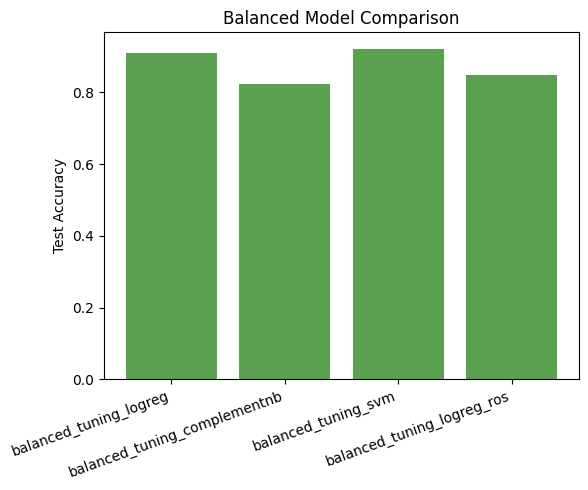

In [23]:
# Get target names
target_names = ['negative','neutral','positive']

# Get balanced models
models = create_balanced_models()

# Evaluate
results = []
for name, model in models.items():
    res = evaluate_and_log_model(name, model, X_train, X_test, y_train, y_test, target_names)
    results.append(res)

# Compare test accuracies
plt.figure(figsize=(6,5))
plt.bar([r['name'] for r in results], [r['test_acc'] for r in results], color='#59a14f')
plt.xticks(rotation=20, ha='right')
plt.ylabel('Test Accuracy')
plt.title('Balanced Model Comparison')
plt.tight_layout()
plt.savefig('./results/balanced_model_comparison.png', dpi=120)
plt.show()

# Redoing Subsets for Class Imbalance

In [46]:
df.columns

Index(['Id', 'Review', 'Label', 'processed', 'is_english', 'Sentiment',
       'Sentiment_encoded'],
      dtype='object')

In [47]:
n_per_class = 4720

df_balanced = (
    df.groupby('Sentiment_encoded', group_keys=False, sort=False)
      .apply(lambda g: g.sample(n=n_per_class, random_state=42), include_groups=False)
      .sample(frac=1, random_state=42)  # shuffle
      .reset_index(drop=True)
)

X = df_balanced['processed']
y = df_balanced['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print("Train:", len(X_train), "Test:", len(X_test))
print("Train class counts:\n", y_train.value_counts())
print("Test class counts:\n", y_test.value_counts())

Train: 9912 Test: 4248
Train class counts:
 Sentiment
negative    3304
neutral     3304
positive    3304
Name: count, dtype: int64
Test class counts:
 Sentiment
positive    1416
negative    1416
neutral     1416
Name: count, dtype: int64


In [48]:
tfidf = TfidfVectorizer(
    max_features=10000,      
    ngram_range=(1, 2),      
    stop_words='english',    
    sublinear_tf=True        
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf  = tfidf.transform(X_test)

print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

Train shape: (9912, 10000)
Test shape: (4248, 10000)


In [49]:
tfidf.fit(X_train)
print("Actual features:", len(tfidf.get_feature_names_out()))


Actual features: 10000


In [50]:
models = {
    "Logistic_Regression_BALANCED": LogisticRegression(max_iter=1000),
    "Naive_Bayes_BALANCED": MultinomialNB(),
    "Linear_SVM_BALANCED": LinearSVC()
}

results = []

for name, model in models.items():
    result = evaluate_and_log_model(name, model, X_train_tfidf, X_test_tfidf, y_train, y_test, target_names=['negative','neutral','positive'])
    results.append(result)


🚀 Training Logistic_Regression_BALANCED...
✅ Logistic_Regression_BALANCED trained in 0.24s | Train Acc=0.8507 | Test Acc=0.6605
📂 Logs saved under: ./results/Logistic_Regression_BALANCED


🚀 Training Naive_Bayes_BALANCED...
✅ Naive_Bayes_BALANCED trained in 0.01s | Train Acc=0.8205 | Test Acc=0.6660
📂 Logs saved under: ./results/Naive_Bayes_BALANCED


🚀 Training Linear_SVM_BALANCED...
✅ Linear_SVM_BALANCED trained in 0.06s | Train Acc=0.9433 | Test Acc=0.6396
📂 Logs saved under: ./results/Linear_SVM_BALANCED



In [51]:
models = {
    "LogReg": LogisticRegression(max_iter=1000),
    "NB": MultinomialNB(),
    "SVM": LinearSVC(),
    "RF": RandomForestClassifier(n_estimators=200, n_jobs=-1),
    "LGBM": LGBMClassifier(n_estimators=300, num_leaves=64, n_jobs=-1)
}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    print(f"\n{name}")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Macro-F1:", f1_score(y_test, y_pred, average='macro'))


LogReg
Accuracy: 0.6605461393596986
Macro-F1: 0.6607557767630488

NB
Accuracy: 0.6659604519774012
Macro-F1: 0.6651012080070066

SVM
Accuracy: 0.6395951035781544
Macro-F1: 0.638435666129081

RF
Accuracy: 0.6358286252354048
Macro-F1: 0.6312225858338149
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0,024681 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 42812
[LightGBM] [Info] Number of data points in the train set: 9912, number of used features: 1461
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612
[LightGBM] [Info] Start training from score -1,098612

LGBM
Accuracy: 0.6226459510357816
Macro-F1: 0.6228008328934432


c:\Users\alex7\anaconda3\envs\NLP_ENV_ITRPA\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [56]:
# XGBoost
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

xgb = XGBClassifier(
    n_estimators=300,        
    learning_rate=0.1,       
    max_depth=6,            
    subsample=0.8,           
    colsample_bytree=0.8,    
    objective='multi:softprob',  
    num_class=3,             
    eval_metric='mlogloss',  
    n_jobs=-1,
    random_state=42,
    use_label_encoder=False  
)

# --- Train ---
xgb.fit(X_train_tfidf.toarray(), y_train_enc)

# --- Predict ---
y_pred = xgb.predict(X_test_tfidf.toarray())

# --- Evaluate ---
print("Accuracy:", accuracy_score(y_test_enc, y_pred))
print("Macro-F1:", f1_score(y_test_enc, y_pred, average='macro'))
print(classification_report(y_test_enc, y_pred, target_names=['negative','neutral','positive']))


c:\Users\alex7\anaconda3\envs\NLP_ENV_ITRPA\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:06:41] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.6471280602636534
Macro-F1: 0.6467702662348104
              precision    recall  f1-score   support

    negative       0.62      0.67      0.65      1416
     neutral       0.56      0.53      0.54      1416
    positive       0.76      0.74      0.75      1416

    accuracy                           0.65      4248
   macro avg       0.65      0.65      0.65      4248
weighted avg       0.65      0.65      0.65      4248



# Hyper Parameter Tuning

In [80]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for i, (_, val_idx) in enumerate(cv.split(X_train_tfidf, y_train_enc )):
    print(f"Fold {i+1}: class counts -> {np.bincount(y_train_enc[val_idx])}")

Fold 1: class counts -> [1102 1101 1101]
Fold 2: class counts -> [1101 1102 1101]
Fold 3: class counts -> [1101 1101 1102]


In [77]:
f1_macro = make_scorer(f1_score, average='macro')
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'saga'],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced']
}

lr = LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42)

grid_lr = GridSearchCV(
    lr,
    param_grid_lr,
    scoring=f1_macro,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    error_score=0
)

grid_lr.fit(X_train_tfidf, y_train_enc)
print("Best LR params:", grid_lr.best_params_)
print("Best LR macro-F1:", grid_lr.best_score_)
tuned_logreg = grid_lr.best_estimator_


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best LR params: {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'lbfgs'}
Best LR macro-F1: 0.6607111866449021


In [78]:
results_lr = evaluate_and_log_model(
    name="tuned_logreg",
    model=tuned_logreg,
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train_enc,
    y_test=y_test_enc,
    target_names=target_names
)


🚀 Training tuned_logreg...
✅ tuned_logreg trained in 1.19s | Train Acc=0.8507 | Test Acc=0.6605
📂 Logs saved under: ./results/tuned_logreg



In [81]:
nb = MultinomialNB()

param_grid_nb = {
    "alpha": [0.1, 0.3, 0.5, 1.0, 2.0],
    "fit_prior": [True, False]
}

grid_nb = GridSearchCV(
    estimator=nb,
    param_grid=param_grid_nb,
    scoring=f1_macro,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    error_score=0
)

grid_nb.fit(X_train_tfidf, y_train_enc)

print("\n🔍 Best NB params:", grid_nb.best_params_)
print("🏁 Best NB macro-F1 (CV):", grid_nb.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits

🔍 Best NB params: {'alpha': 2.0, 'fit_prior': False}
🏁 Best NB macro-F1 (CV): 0.6675720733854807


In [82]:
svm = LinearSVC(max_iter=2000, random_state=42)

param_grid_svm = {
    "C": [0.01, 0.1, 1, 10],
    "loss": ["hinge", "squared_hinge"],
    "class_weight": [None, "balanced"]
}

grid_svm = GridSearchCV(
    estimator=svm,
    param_grid=param_grid_svm,
    scoring=f1_macro,
    cv=cv,
    n_jobs=-1,
    verbose=2,
    error_score=0
)

grid_svm.fit(X_train_tfidf, y_train_enc)

print("\n🔍 Best SVM params:", grid_svm.best_params_)
print("🏁 Best SVM macro-F1 (CV):", grid_svm.best_score_)


Fitting 3 folds for each of 16 candidates, totalling 48 fits

🔍 Best SVM params: {'C': 0.1, 'class_weight': 'balanced', 'loss': 'squared_hinge'}
🏁 Best SVM macro-F1 (CV): 0.6619972343650874


In [83]:
tuned_nb = grid_nb.best_estimator_
tuned_svm = grid_svm.best_estimator_


In [84]:
target_names = ["negative", "neutral", "positive"]

evaluate_and_log_model(
    name="tuned_nb",
    model=tuned_nb,
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train_enc,
    y_test=y_test_enc,
    target_names=target_names
)

evaluate_and_log_model(
    name="tuned_svm",
    model=tuned_svm,
    X_train=X_train_tfidf,
    X_test=X_test_tfidf,
    y_train=y_train_enc,
    y_test=y_test_enc,
    target_names=target_names
)



🚀 Training tuned_nb...
✅ tuned_nb trained in 0.00s | Train Acc=0.8036 | Test Acc=0.6645
📂 Logs saved under: ./results/tuned_nb


🚀 Training tuned_svm...
✅ tuned_svm trained in 0.02s | Train Acc=0.8202 | Test Acc=0.6681
📂 Logs saved under: ./results/tuned_svm



{'name': 'tuned_svm',
 'train_acc': 0.8202179176755447,
 'test_acc': 0.6680790960451978,
 'train_time': 0.02460479736328125}

# Transfer The preprocessed Data to Object Pickling 

In [87]:
# --- ensure output folder exists ---
os.makedirs('outputs_processing', exist_ok=True)

# --- save all useful data ---
with open('outputs_processing/processed_data.pkl', 'wb') as f:
    pickle.dump({
        # TF-IDF features
        'X_train_tfidf': X_train_tfidf,
        'X_test_tfidf': X_test_tfidf,
        
        # Encoded labels
        'y_train_enc': y_train_enc,
        'y_test_enc': y_test_enc,
        
        # Raw text (for DL / tokenizers)
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,

        # X and y
        'X': X,
        'y': y,
    }, f)

print("Saved: outputs_processing/processed_data.pkl (TF-IDF, encoded labels, and raw text)")

Saved: outputs_processing/processed_data.pkl (TF-IDF, encoded labels, and raw text)
